# 6. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

data set: Naver sentiment movie corpus (네이버 영화의 댓글 사용)

# 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

가공되지 않은 텍스트 파일이므로, data_loader 다음을 수행한다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
  

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
print('word_to_index : ',len(word_to_index), type(word_to_index))

훈련 샘플 개수: 146182, 테스트 개수: 49157
word_to_index :  9997 <class 'dict'>


- word_to_index에는 어떤 내용이 들어있는지 확인한다.
- word_to_index는 word:index 형태로 묶인 데이터들의 집합이다.
- 확인해 보면, 앞쪽에 있어야 할 PAD, BOS, UNK가 나타나지 않았음을 알 수 있다. 이들을 각각 index 0, 1, 2로 대응시켜 딕셔너리에 포함시킨다.

In [4]:
word_to_index = {k:(v) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 

<BOS>


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  60
전체 문장의 0.9882255975509243%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


print(X_train.shape)
print(X_test.shape)

(146182, 60)
(49157, 60)


146182은 입력문장 개수, 60는 입력문장의 최대 길이, 4는 워드 벡터의 차원 수

# 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.

In [9]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 4 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [10]:
# GlobalMaxPooling1D
model1 = tf.keras.Sequential(name='GMP')
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d (Global (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [11]:
# LSTM
model2 = tf.keras.Sequential(name='LSTM')
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()
#단어하나마다 연속성이 없어서 none을 쓴다.


Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


In [12]:
# RNN 모델
model3 = tf.keras.Sequential(name='RNN')
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9       

In [13]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 60)
(136182,)


# 5) 모델 훈련 개시

In [14]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
286/286 [==============================] - 2s 4ms/step - loss: 0.6198 - accuracy: 0.7085 - val_loss: 0.4879 - val_accuracy: 0.8131
Epoch 2/10
286/286 [==============================] - 1s 3ms/step - loss: 0.4336 - accuracy: 0.8169 - val_loss: 0.3771 - val_accuracy: 0.8405
Epoch 3/10
286/286 [==============================] - 1s 3ms/step - loss: 0.3775 - accuracy: 0.8373 - val_loss: 0.3439 - val_accuracy: 0.8547
Epoch 4/10
286/286 [==============================] - 1s 3ms/step - loss: 0.3554 - accuracy: 0.8468 - val_loss: 0.3261 - val_accuracy: 0.8625
Epoch 5/10
286/286 [==============================] - 1s 3ms/step - loss: 0.3417 - accuracy: 0.8537 - val_loss: 0.3150 - val_accuracy: 0.8672
Epoch 6/10
286/286 [==============================] - 1s 3ms/step - loss: 0.3325 - accuracy: 0.8581 - val_loss: 0.3063 - val_accuracy: 0.8694
Epoch 7/10
286/286 [==============================] - 1s 3ms/step - loss: 0.3254 - accuracy: 0.8618 - val_loss: 0.3006 - val_accuracy: 0.8722
Epoch 

In [15]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
286/286 [==============================] - 4s 7ms/step - loss: 0.5053 - accuracy: 0.7677 - val_loss: 0.3487 - val_accuracy: 0.8571
Epoch 2/10
286/286 [==============================] - 2s 6ms/step - loss: 0.3469 - accuracy: 0.8534 - val_loss: 0.3125 - val_accuracy: 0.8692
Epoch 3/10
286/286 [==============================] - 2s 6ms/step - loss: 0.3254 - accuracy: 0.8634 - val_loss: 0.2994 - val_accuracy: 0.8760
Epoch 4/10
286/286 [==============================] - 2s 5ms/step - loss: 0.3158 - accuracy: 0.8689 - val_loss: 0.2922 - val_accuracy: 0.8806
Epoch 5/10
286/286 [==============================] - 2s 6ms/step - loss: 0.3112 - accuracy: 0.8693 - val_loss: 0.2875 - val_accuracy: 0.8825
Epoch 6/10
286/286 [==============================] - 2s 6ms/step - loss: 0.3071 - accuracy: 0.8722 - val_loss: 0.2861 - val_accuracy: 0.8830
Epoch 7/10
286/286 [==============================] - 2s 5ms/step - loss: 0.3053 - accuracy: 0.8732 - val_loss: 0.2852 - val_accuracy: 0.8856
Epoch 

In [16]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
286/286 [==============================] - 3s 5ms/step - loss: 0.6082 - accuracy: 0.6539 - val_loss: 0.4708 - val_accuracy: 0.7656
Epoch 2/10
286/286 [==============================] - 1s 4ms/step - loss: 0.4546 - accuracy: 0.7751 - val_loss: 0.4156 - val_accuracy: 0.7984
Epoch 3/10
286/286 [==============================] - 1s 4ms/step - loss: 0.4243 - accuracy: 0.7907 - val_loss: 0.3989 - val_accuracy: 0.8077
Epoch 4/10
286/286 [==============================] - 1s 4ms/step - loss: 0.4081 - accuracy: 0.8000 - val_loss: 0.3830 - val_accuracy: 0.8167
Epoch 5/10
286/286 [==============================] - 1s 5ms/step - loss: 0.3950 - accuracy: 0.8068 - val_loss: 0.3712 - val_accuracy: 0.8215
Epoch 6/10
286/286 [==============================] - 1s 4ms/step - loss: 0.3841 - accuracy: 0.8130 - val_loss: 0.3591 - val_accuracy: 0.8286
Epoch 7/10
286/286 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.8180 - val_loss: 0.3511 - val_accuracy: 0.8255
Epoch 

In [17]:
#학습이 끝난 모델을 테스트셋으로 평가해 봅니다.
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results1)
print(results2)
print(results3)

1537/1537 - 2s - loss: 0.3964 - accuracy: 0.8270
1537/1537 - 3s - loss: 0.3617 - accuracy: 0.8457
1537/1537 - 2s - loss: 0.5073 - accuracy: 0.7592
[0.3963540494441986, 0.8270439505577087]
[0.36165350675582886, 0.8456577658653259]
[0.5072503089904785, 0.7592000961303711]


# 6) Loss, Accuracy 그래프 시각화

In [18]:
import matplotlib.pyplot as plt

history1_dict = history1.history
history2_dict = history2.history
history3_dict = history3.history

print(history1_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


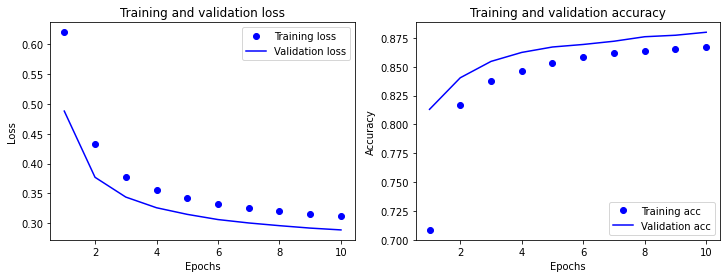

In [19]:
# GlobalMaxPooling1D 그래프

acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

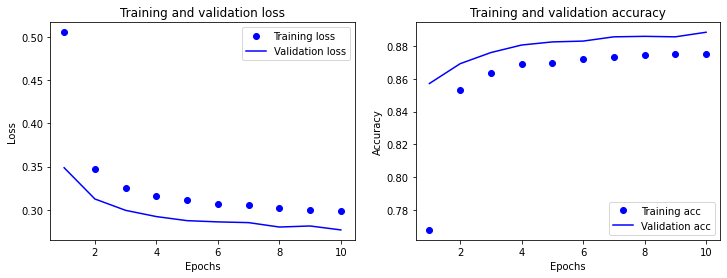

In [20]:
# LSTM 그래프

acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

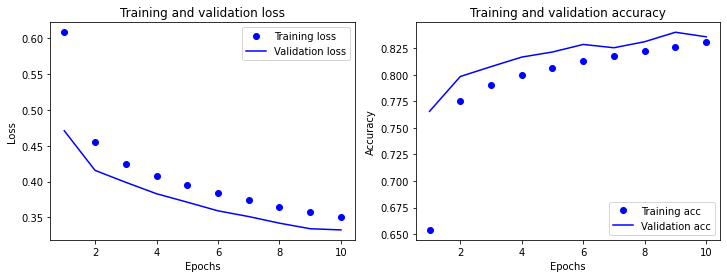

In [21]:
# RNN 그래프

acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

워드 임베딩(word embedding) 기법
- 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법으로 단어의 특성을 저차원 벡터값으로 표현할 수 있다.

In [22]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [23]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [25]:
word_vectors.similar_by_word('작가')

[('그리스', 0.9984428286552429),
 ('어눌', 0.9983808994293213),
 ('티나', 0.9981387257575989),
 ('나무', 0.9975257515907288),
 ('껍데기', 0.9969538450241089),
 ('힌', 0.9965128898620605),
 ('대변', 0.99641352891922),
 ('죽일', 0.996186375617981),
 ('정극', 0.9961296916007996),
 ('13', 0.9955528378486633)]

In [26]:
word_vectors.similar_by_word("당근")

[('느껴졌', 0.9999872446060181),
 ('김동완', 0.9998558759689331),
 ('당대', 0.9998287558555603),
 ('love', 0.9998224973678589),
 ('마주', 0.9998016357421875),
 ('곁', 0.9997525215148926),
 ('무법자', 0.9997431635856628),
 ('！', 0.9996116757392883),
 ('그리운', 0.9996038675308228),
 ('드릴게요', 0.9995906352996826)]

결과를 보면 '작가', '당근'와 유사한 다른 단어를 잘 찾았다고 느껴지지않는다.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec 데이터를 불러와 사용하였다.



In [27]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec =Word2Vec.load(word2vec_path)
vector = word2vec['당근']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_592/2679171022.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['당근']


(200,)

In [28]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("당근")

/tmp/ipykernel_592/1470220425.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("당근")


[('마늘', 0.8946298360824585),
 ('생강', 0.8882328271865845),
 ('시금치', 0.8663696050643921),
 ('땅콩', 0.8553698062896729),
 ('코코넛', 0.8416827917098999),
 ('시럽', 0.8391491174697876),
 ('생선', 0.838982343673706),
 ('계란', 0.8304873704910278),
 ('식초', 0.8282333612442017),
 ('벌꿀', 0.8194385766983032)]

In [29]:
word2vec.similar_by_word("봉")

/tmp/ipykernel_592/1426275012.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("봉")


[('식읍', 0.5776339173316956),
 ('천군', 0.5521209239959717),
 ('조양', 0.5519270896911621),
 ('봉리', 0.5486885905265808),
 ('화천', 0.5472432971000671),
 ('부원군', 0.5438313484191895),
 ('석문', 0.5420047044754028),
 ('봉산', 0.541691780090332),
 ('청천', 0.5397597551345825),
 ('이천', 0.5372180938720703)]

In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_592/1324384006.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_592/1324384006.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [31]:
# 모델 구성
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.LSTM(16))
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [32]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
286/286 [==============================] - 4s 9ms/step - loss: 0.4797 - accuracy: 0.7633 - val_loss: 0.3425 - val_accuracy: 0.8539
Epoch 2/10
286/286 [==============================] - 2s 7ms/step - loss: 0.3403 - accuracy: 0.8548 - val_loss: 0.3033 - val_accuracy: 0.8702
Epoch 3/10
286/286 [==============================] - 2s 7ms/step - loss: 0.3044 - accuracy: 0.8719 - val_loss: 0.2648 - val_accuracy: 0.8901
Epoch 4/10
286/286 [==============================] - 2s 7ms/step - loss: 0.2833 - accuracy: 0.8823 - val_loss: 0.2503 - val_accuracy: 0.8991
Epoch 5/10
286/286 [==============================] - 2s 7ms/step - loss: 0.2660 - accuracy: 0.8908 - val_loss: 0.2391 - val_accuracy: 0.9039
Epoch 6/10
286/286 [==============================] - 2s 7ms/step - loss: 0.2500 - accuracy: 0.8984 - val_loss: 0.2165 - val_accuracy: 0.9165
Epoch 7/10
286/286 [==============================] - 2s 7ms/step - loss: 0.2360 - accuracy: 0.9054 - val_loss: 0.2079 - val_accuracy: 0.9183
Epoch 

In [33]:
# 테스트셋을 통한 모델 평가
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 3s - loss: 0.3776 - accuracy: 0.8519
[0.3775843679904938, 0.851862370967865]


<Figure size 432x288 with 0 Axes>

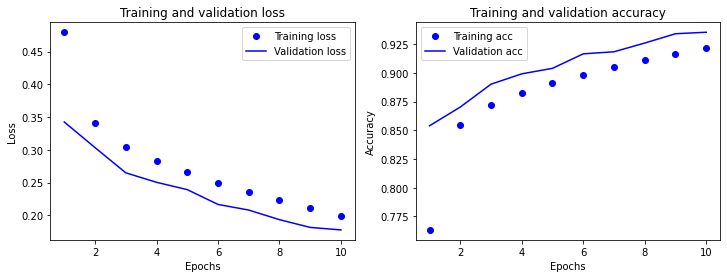

In [34]:
# 한국어 Word2Vec 임베딩 활용한 모델 그래프

history4_dict = history4.history

acc = history4_dict['accuracy']
val_acc = history4_dict['val_accuracy']
loss = history4_dict['loss']
val_loss = history4_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

정확도 향상은 잘 모르겠다.


# 회고
네이버 영화 리뷰 감성 분석 프로젝트를 진행하면서 한국어 임베딩을 활용하여 성능 개선하려는 부분에서 파일 로드가 안되는 오류가 있었다.

Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

위와 같은 오류는 gensim의 버전 문제 때문

4.0.X 버전부터는 vocab이라는 코드가 gensim 패키지에서 사라졌기때문에 코드를 사용하여 ko.bin을 로드하려면 gensim의 버전에 3.8.X여야만 한다고 한다.

pip install --upgrade gensim==3.8.3

하다가 포기할뻔 했다.

너무 힘들었다.

오류가 많이 나서 오류 찾는 시간이 많았다.

그렇지만 했다.